# AgiBot 数据可视化与验证工具

本 Notebook 用于可视化和验证 AgiBot 机器人的 `proprio_stats.h5` 数据文件，包括：
1. **数据结构浏览** - 查看 HDF5 文件的完整结构
2. **末端执行器可视化** - 7自由度（位置xyz + 姿态四元数）
3. **关节角度可视化** - 14自由度（左右臂各7个关节）
4. **差异分析** - 验证原始数据中 State 与 Action 的差异
5. **正运动学验证** - 通过FK验证末端执行器位姿精度

---

## 配置说明

修改下方代码单元格中的 `path` 变量来选择不同的 HDF5 数据文件


In [25]:
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# 📌 Configuration: Modify path to select different HDF5 file
# Can use remote path or local sample_dataset
# path = Path("/mnt/raid0/AgiBot_Word_Beta/proprio_stats/358/654803/proprio_stats.h5")
path = Path("/home/unitree/桌面/agibot_world_eef/sample_dataset/proprio_stats/384/655302/proprio_stats.h5")

print(f"Loading data file: {path}")
print(f"File exists: {path.exists()}")

def walk(name, obj, indent=0):
    """Recursively traverse HDF5 file structure"""
    prefix = "  " * indent
    if isinstance(obj, h5py.Group):
        print(f"{prefix}{name}/")
        for k, v in obj.items():
            walk(k, v, indent + 1)
    else:
        print(f"{prefix}{name}  [shape={obj.shape}, dtype={obj.dtype}]")

print("\nHDF5 File Structure:")
print("=" * 80)
with h5py.File(path, "r") as f:
    for k, v in f.items():
        walk(k, v, 0)
print("=" * 80)


Loading data file: /home/unitree/桌面/agibot_world_eef/sample_dataset/proprio_stats/384/655302/proprio_stats.h5
File exists: True

HDF5 File Structure:
action/
  effector/
    force  [shape=(0,), dtype=float32]
    index  [shape=(1530,), dtype=int64]
    position  [shape=(1530, 2), dtype=float64]
  end/
    index  [shape=(1338,), dtype=int64]
    orientation  [shape=(1530, 2, 4), dtype=float64]
    position  [shape=(1530, 2, 3), dtype=float64]
  head/
    index  [shape=(1530,), dtype=int64]
    position  [shape=(1530, 2), dtype=float64]
  joint/
    effort  [shape=(0,), dtype=float32]
    index  [shape=(1338,), dtype=int64]
    position  [shape=(1530, 14), dtype=float64]
    velocity  [shape=(0,), dtype=float32]
  robot/
    angular  [shape=(0,), dtype=float32]
    index  [shape=(1530,), dtype=int64]
    orientation  [shape=(0,), dtype=float32]
    position  [shape=(0,), dtype=float32]
    velocity  [shape=(1530, 2), dtype=float64]
  waist/
    index  [shape=(1530,), dtype=int64]
    pos

## 2. 末端执行器可视化（7自由度）

可视化末端执行器的 **7 自由度**数据：
- **位置**：X, Y, Z（3维坐标）
- **姿态**：Qx, Qy, Qz, Qw（四元数表示，4维）

对比 **State**（实际状态）与 **Action**（原始动作数据，未经时间偏移处理）的差异



End-effector data shapes:
  Action position: (1530, 2, 3) - [timesteps, 2 arms, xyz]
  Action orientation: (1530, 2, 4) - [timesteps, 2 arms, quaternion xyzw]
  State position: (1530, 2, 3)
  State orientation: (1530, 2, 4)


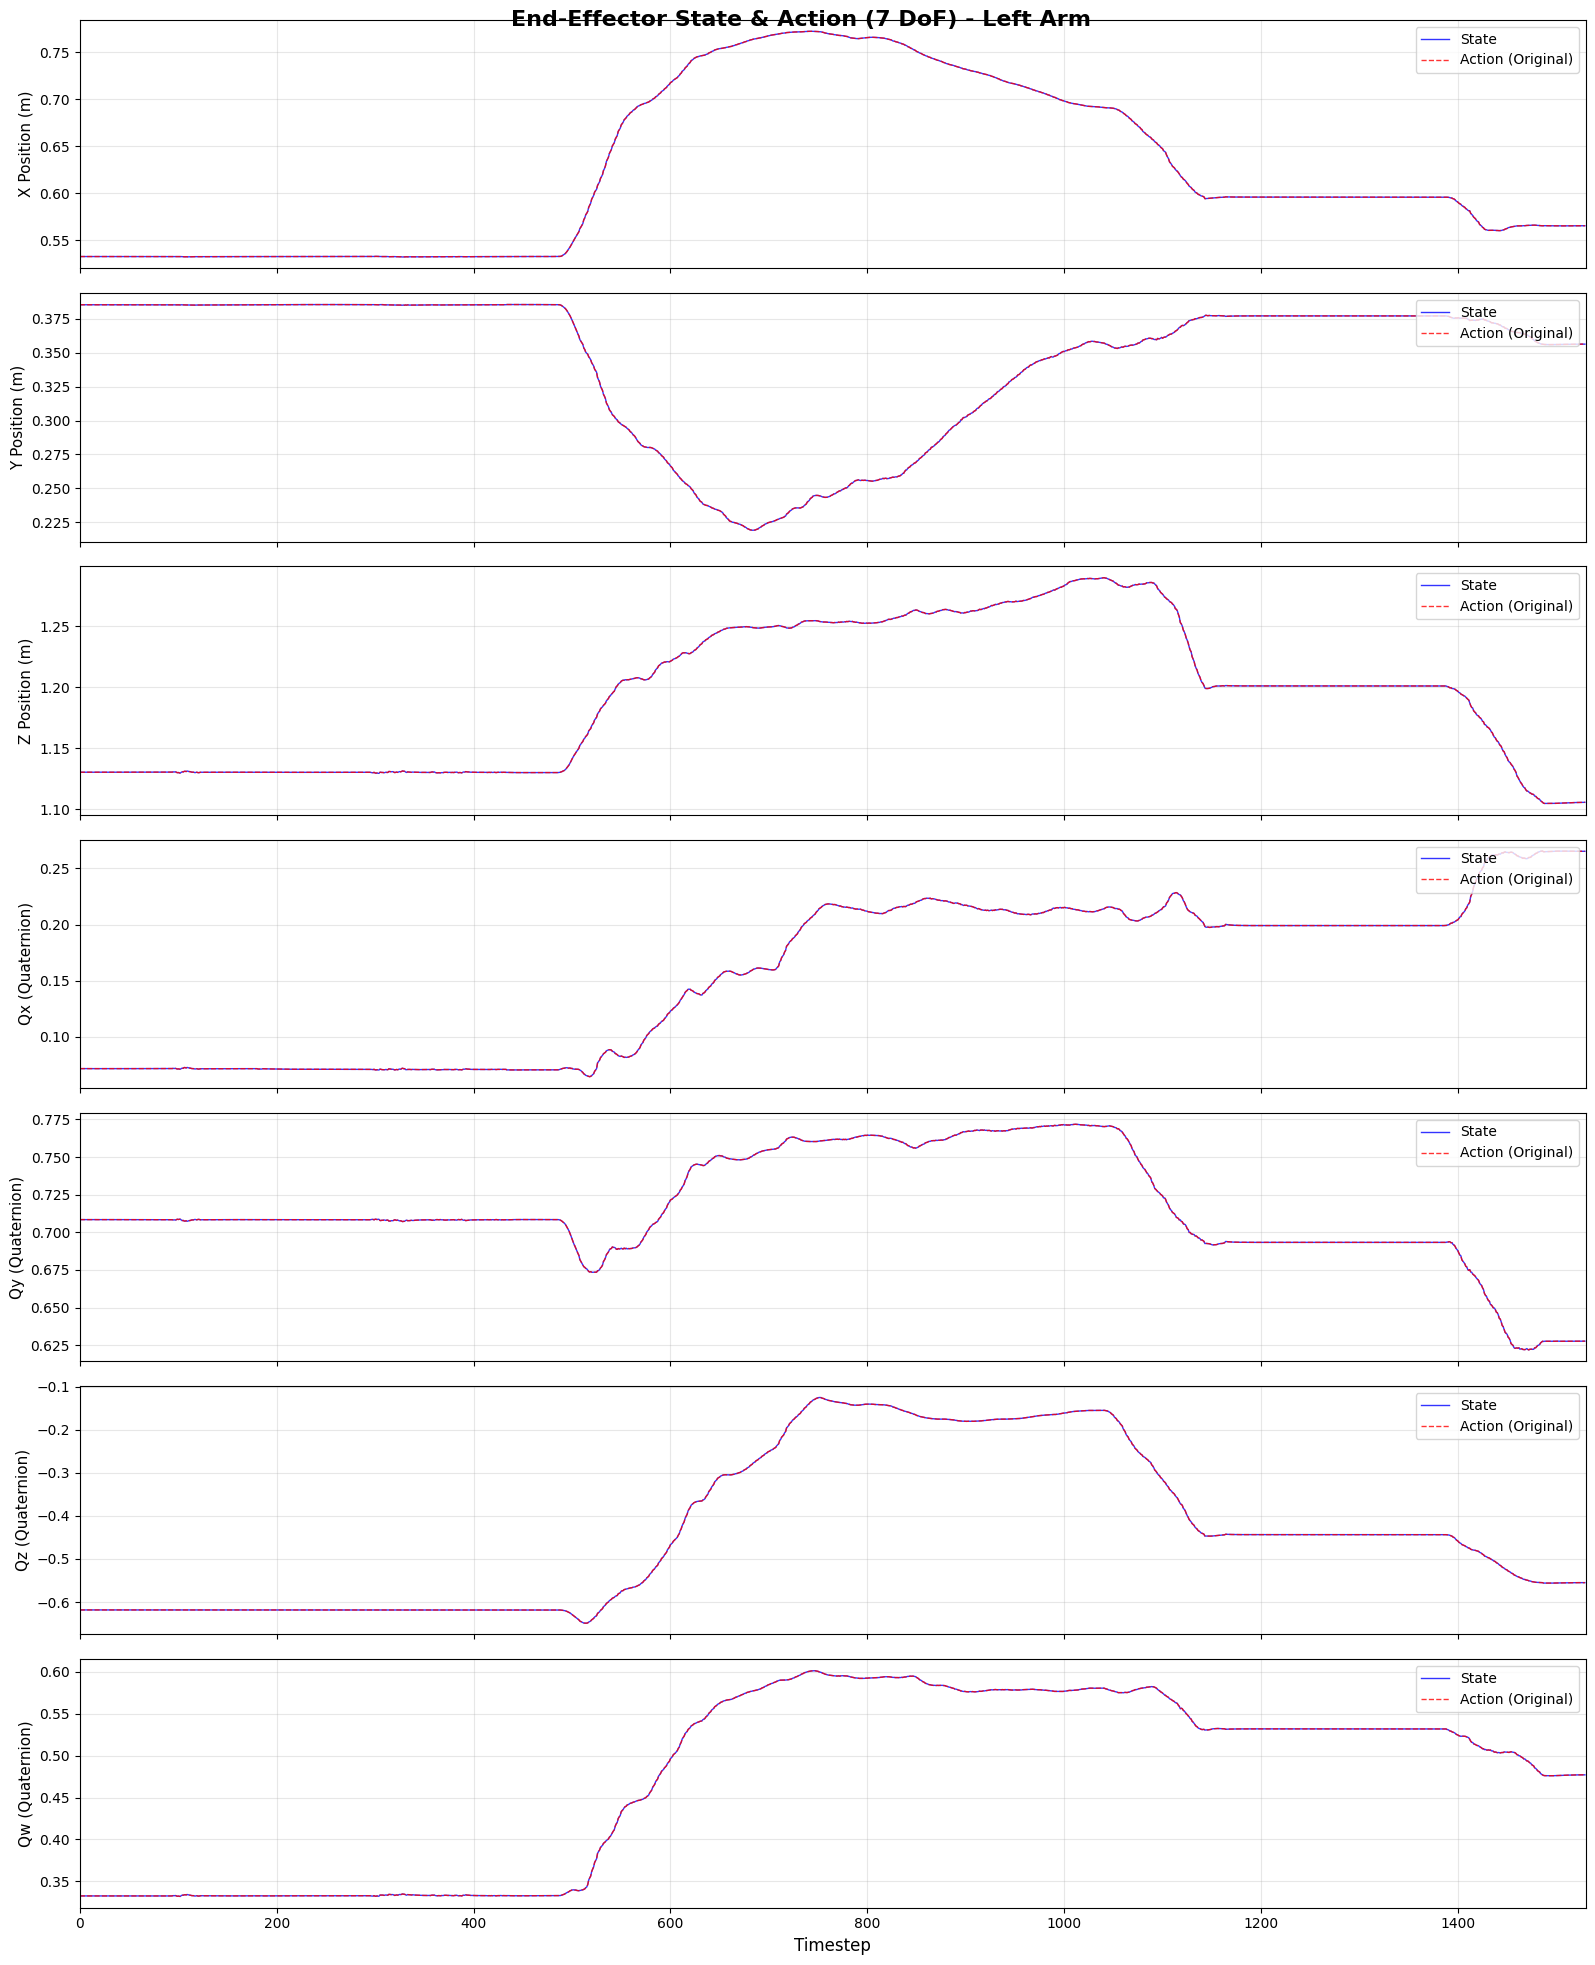


Note: Blue solid line = State (actual), Red dashed line = Action (original HDF5)
      In our data processing, action[t] is replaced with state[t+1]


In [26]:
# Read end-effector data
with h5py.File(path, "r") as f:
    # Action: end effector (original action in HDF5)
    action_position = f["action/end/position"][:]      # (T, 2, 3)
    action_orientation = f["action/end/orientation"][:]  # (T, 2, 4)
    
    # State: end effector
    state_position = f["state/end/position"][:]        # (T, 2, 3)
    state_orientation = f["state/end/orientation"][:]    # (T, 2, 4)

print(f"\nEnd-effector data shapes:")
print(f"  Action position: {action_position.shape} - [timesteps, 2 arms, xyz]")
print(f"  Action orientation: {action_orientation.shape} - [timesteps, 2 arms, quaternion xyzw]")
print(f"  State position: {state_position.shape}")
print(f"  State orientation: {state_orientation.shape}")

# Time axis
timesteps = np.arange(action_position.shape[0])

# Select left arm (index 0) or right arm (index 1)
arm_idx = 0  # 📌 Change here to select left(0) or right(1) arm

# Extract data
action_pos = action_position[:, arm_idx, :]  # (T, 3)
action_ori = action_orientation[:, arm_idx, :]  # (T, 4)
state_pos = state_position[:, arm_idx, :]  # (T, 3)
state_ori = state_orientation[:, arm_idx, :]  # (T, 4)

# Create figure with 7 subplots
fig, axes = plt.subplots(7, 1, figsize=(16, 20), sharex=True)
fig.suptitle(f'End-Effector State & Action (7 DoF) - {"Left Arm" if arm_idx == 0 else "Right Arm"}', 
             fontsize=16, fontweight='bold')

# Position labels
pos_labels = ['X Position (m)', 'Y Position (m)', 'Z Position (m)']
# Quaternion labels
ori_labels = ['Qx (Quaternion)', 'Qy (Quaternion)', 'Qz (Quaternion)', 'Qw (Quaternion)']

# Plot position (3 dimensions)
for i in range(3):
    ax = axes[i]
    ax.plot(timesteps, state_pos[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_pos[:, i], 'r--', label='Action (Original)', alpha=0.8, linewidth=1)
    ax.set_ylabel(pos_labels[i], fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# Plot orientation/quaternion (4 dimensions)
for i in range(4):
    ax = axes[3 + i]
    ax.plot(timesteps, state_ori[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_ori[:, i], 'r--', label='Action (Original)', alpha=0.8, linewidth=1)
    ax.set_ylabel(ori_labels[i], fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# Set x-axis label
axes[-1].set_xlabel('Timestep', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nNote: Blue solid line = State (actual), Red dashed line = Action (original HDF5)")
print(f"      In our data processing, action[t] is replaced with state[t+1]")


## 3. 关节角度可视化（14自由度）

可视化机器人的 **14 个关节角度**（单位：弧度）：
- **左臂**：7 个关节（Joint 1-7）
- **右臂**：7 个关节（Joint 8-14）

对比 State 和 Action 的关节角度变化


Joint angle data shapes:
  Action: (1530, 14) - [timesteps, 14 joints]
  State: (1530, 14)


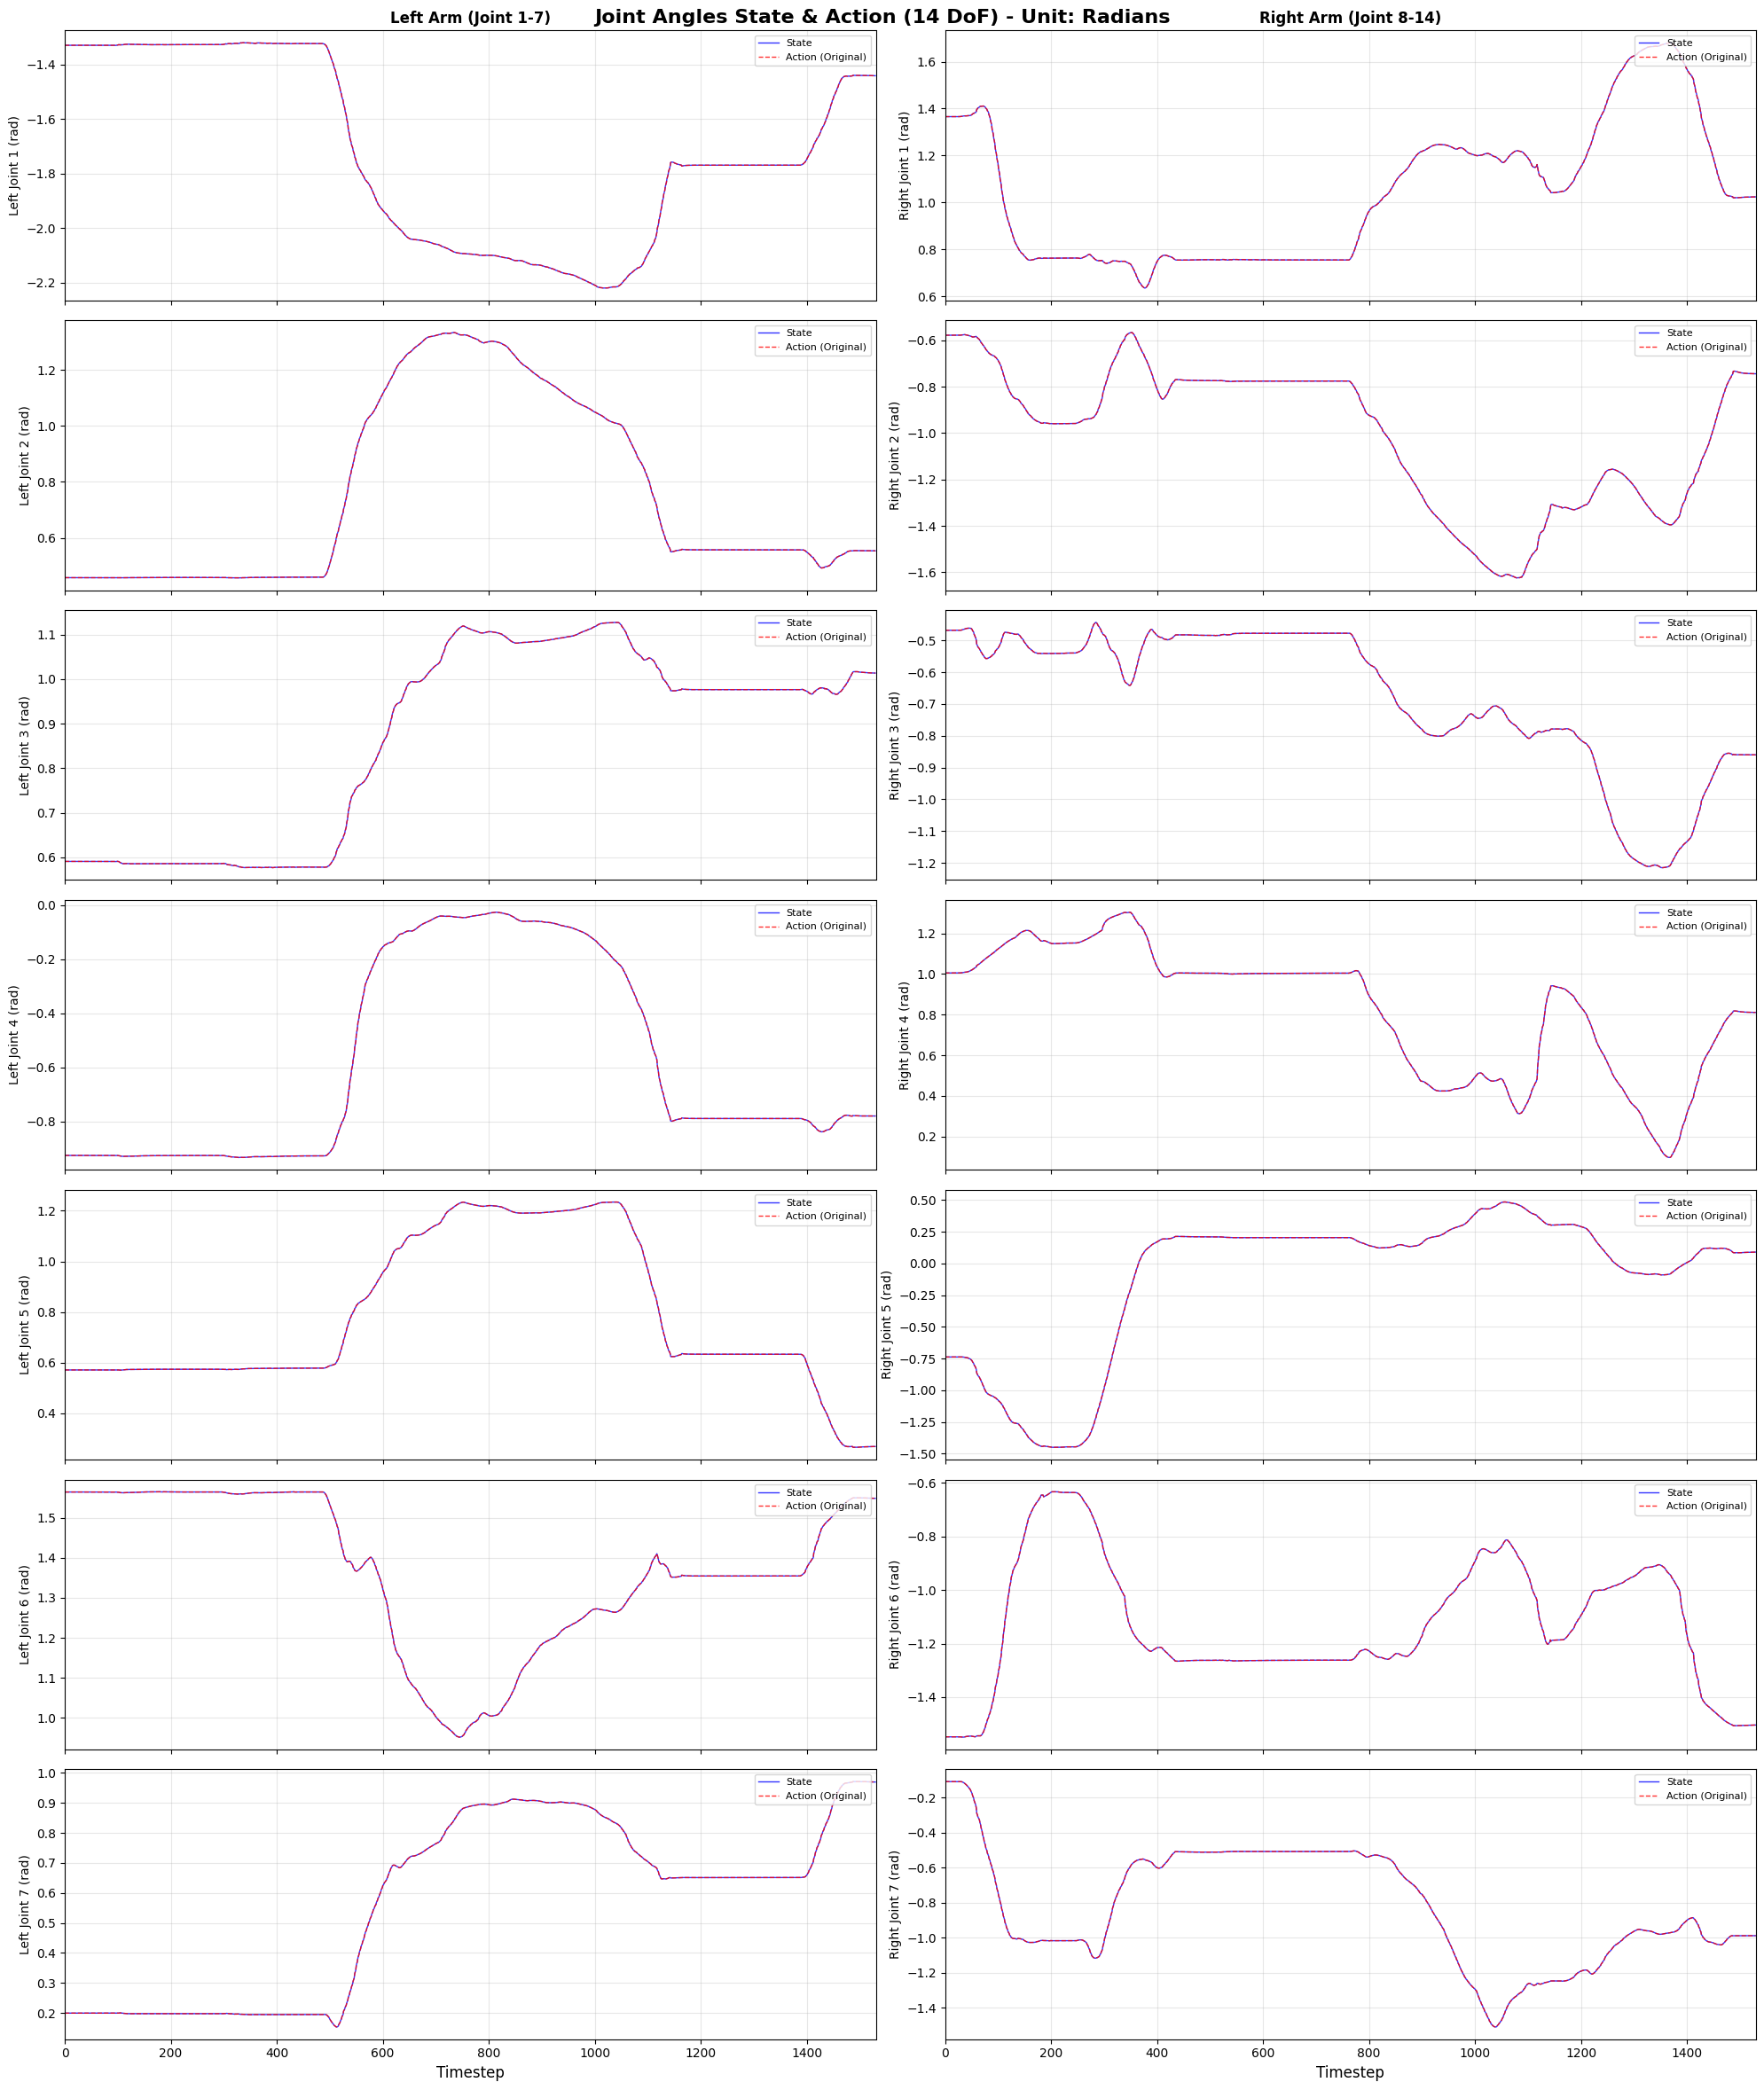


Note: Joint angles are in radians


In [27]:
# Read joint angle data
with h5py.File(path, "r") as f:
    # Action: joint
    action_joint_position = f["action/joint/position"][:]  # (T, 14)
    
    # State: joint
    state_joint_position = f["state/joint/position"][:]  # (T, 14)

print(f"\nJoint angle data shapes:")
print(f"  Action: {action_joint_position.shape} - [timesteps, 14 joints]")
print(f"  State: {state_joint_position.shape}")

# Time axis
timesteps = np.arange(action_joint_position.shape[0])

# Create figure - 14 subplots (2 columns: left arm 7 + right arm 7)
fig, axes = plt.subplots(7, 2, figsize=(20, 24), sharex=True)
fig.suptitle('Joint Angles State & Action (14 DoF) - Unit: Radians', fontsize=16, fontweight='bold')

# Joint labels
joint_labels = [f'Joint {i+1}' for i in range(7)]

# Plot left arm (first 7 joints)
for i in range(7):
    ax = axes[i, 0]
    ax.plot(timesteps, state_joint_position[:, i], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_joint_position[:, i], 'r--', label='Action (Original)', alpha=0.8, linewidth=1)
    ax.set_ylabel(f'Left {joint_labels[i]} (rad)', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# Plot right arm (last 7 joints)
for i in range(7):
    ax = axes[i, 1]
    ax.plot(timesteps, state_joint_position[:, i+7], 'b-', label='State', alpha=0.8, linewidth=1)
    ax.plot(timesteps, action_joint_position[:, i+7], 'r--', label='Action (Original)', alpha=0.8, linewidth=1)
    ax.set_ylabel(f'Right {joint_labels[i]} (rad)', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(timesteps)])

# Set x-axis labels
axes[-1, 0].set_xlabel('Timestep', fontsize=12)
axes[-1, 1].set_xlabel('Timestep', fontsize=12)

# Set column titles
axes[0, 0].set_title('Left Arm (Joint 1-7)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Right Arm (Joint 8-14)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nNote: Joint angles are in radians")


In [28]:
with h5py.File(path, "r") as f:
    action_joint = f["action/joint/position"][:]
    state_joint = f["state/joint/position"][:]

# 计算差异
diff = action_joint - state_joint

print("📊 原始 HDF5 中 Action vs State 的差异统计:")
print("=" * 60)
print(f"  最大差异: {np.max(np.abs(diff)):.6f} rad")
print(f"  平均差异: {np.mean(np.abs(diff)):.6f} rad")
print(f"  标准差:   {np.std(diff):.6f} rad")
print(f"  是否完全相同: {np.allclose(action_joint, state_joint)}")
print("=" * 60)

if np.allclose(action_joint, state_joint):
    print("\n✓ 原始数据中 action 和 state 几乎相同（原作者从 state 复制）")
else:
    print(f"\n⚠️  原始数据中 action 和 state 存在差异")

print(f"\n💡 在我们的数据处理中:")
print(f"   - action[t] = state[t+1] (时间偏移)")
print(f"   - action[-1] = state[-1] (最后一帧)")

📊 原始 HDF5 中 Action vs State 的差异统计:
  最大差异: 0.000000 rad
  平均差异: 0.000000 rad
  标准差:   0.000000 rad
  是否完全相同: True

✓ 原始数据中 action 和 state 几乎相同（原作者从 state 复制）

💡 在我们的数据处理中:
   - action[t] = state[t+1] (时间偏移)
   - action[-1] = state[-1] (最后一帧)


## 4. 正运动学（FK）验证

使用 IKFKSolver 验证末端执行器位姿精度：
- 从关节角度计算末端执行器位姿（正运动学）
- 与 HDF5 中记录的 Ground Truth 进行对比
- 可选择是否使用 gripper 坐标变换

**配置选项**：
- `EEF_MODE = "GRIPPER"`：使用 gripper 中心点（通过变换矩阵计算）
- `EEF_MODE = "ARM"`：使用机械臂末端（直接使用FK输出）


In [29]:
# 导入 FK solver
try:
    from urdf_solver.ikfk_utils import IKFKSolver
    
    # 📌 配置：选择末端执行器模式
    EEF_MODE = "GRIPPER"  # 改这里！"GRIPPER" 或 "ARM"
    
    print(f"✓ IKFKSolver 导入成功")
    print(f"📌 末端执行器模式: {EEF_MODE}")
    
    fk_available = True
except ImportError as e:
    print(f"⚠️  无法导入 IKFKSolver: {e}")
    print(f"   跳过 FK 验证部分")
    fk_available = False

✓ IKFKSolver 导入成功
📌 末端执行器模式: GRIPPER



🔧 初始化 IKFKSolver:
   arm_init: [-1.33024848  0.45767862  0.59096169 -0.92591447]... (14 joints)
   head_init: [0.     0.3141]
   waist_init: [0.12215    0.45349464]
✓ Solver 初始化完成
   模式: GRIPPER (使用 gripper transform)

⏳ 计算 1530 帧的正运动学...
✓ FK 计算完成

📊 位置误差统计:
   左臂: 平均 143.00 mm, 最大 143.00 mm
   右臂: 平均 143.00 mm, 最大 143.00 mm


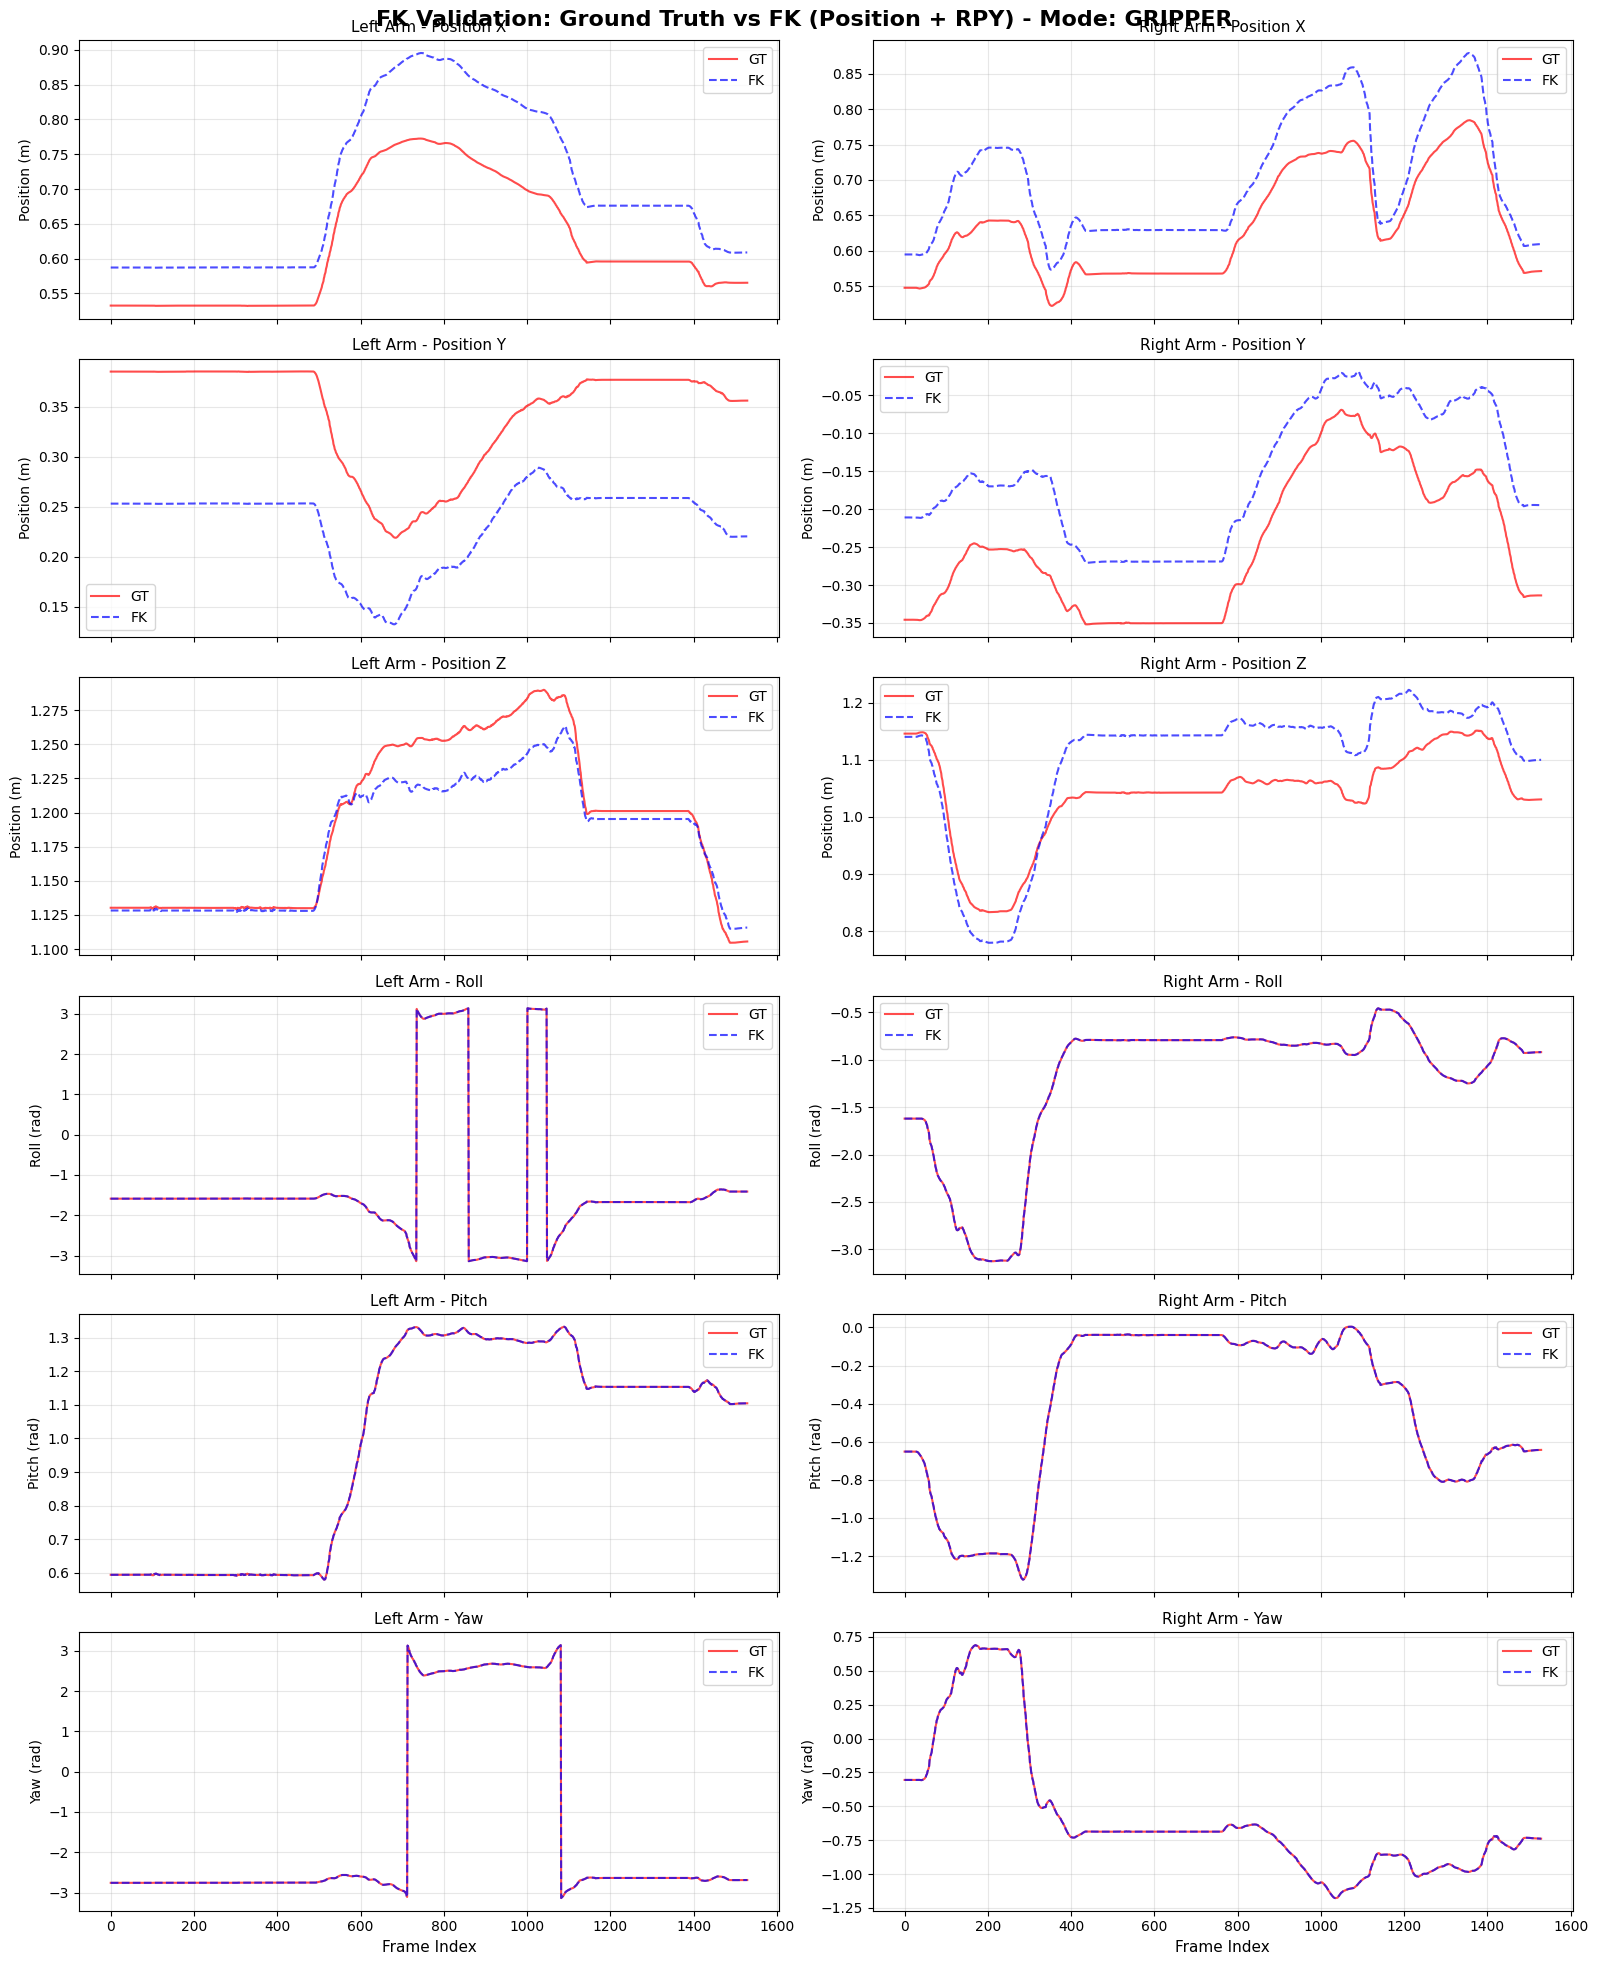

In [30]:
if fk_available and path.exists():
    # 读取数据
    with h5py.File(path, "r") as f:
        state_joint_positions = f["state/joint/position"][:]  # (T, 14)
        state_end_positions = f["state/end/position"][:]  # (T, 2, 3)
        state_end_orientations = f["state/end/orientation"][:]  # (T, 2, 4)
        state_head_positions = f["state/head/position"][:]  # (T, 2)
        state_waist_positions = f["state/waist/position"][:]  # (T, 2)
    
    # 初始化 solver (使用第一帧)
    arm_init = state_joint_positions[0]
    head_init = state_head_positions[0]
    waist_init = state_waist_positions[0]
    
    print(f"\n🔧 初始化 IKFKSolver:")
    print(f"   arm_init: {arm_init[:4]}... (14 joints)")
    print(f"   head_init: {head_init}")
    print(f"   waist_init: {waist_init}")
    
    solver = IKFKSolver(
        arm_init_joint_position=arm_init,
        head_init_position=head_init,
        waist_init_position=waist_init
    )
    
    print(f"✓ Solver 初始化完成")
    print(f"   模式: {EEF_MODE} ({'使用 gripper transform' if EEF_MODE == 'GRIPPER' else '不使用 transform'})")
    
    # 计算所有帧的 FK
    indices = np.arange(len(state_joint_positions))
    
    # 存储结果
    gt_left_pos = []
    gt_right_pos = []
    fk_left_pos = []
    fk_right_pos = []
    
    gt_left_rpy = []
    gt_right_rpy = []
    fk_left_rpy = []
    fk_right_rpy = []
    
    print(f"\n⏳ 计算 {len(indices)} 帧的正运动学...")
    
    for idx in indices:
        arm_joints = state_joint_positions[idx]
        
        # Ground Truth
        gt_left_pos.append(state_end_positions[idx, 0, :])
        gt_right_pos.append(state_end_positions[idx, 1, :])
        
        # 四元数转 RPY (xyzw格式)
        gt_left_quat_xyzw = state_end_orientations[idx, 0, :]
        gt_right_quat_xyzw = state_end_orientations[idx, 1, :]
        
        gt_left_rpy.append(R.from_quat(gt_left_quat_xyzw, scalar_first=False).as_euler("xyz", degrees=False))
        gt_right_rpy.append(R.from_quat(gt_right_quat_xyzw, scalar_first=False).as_euler("xyz", degrees=False))
        
        # FK 计算
        use_gripper_transform = (EEF_MODE == "GRIPPER")
        left_xyzrpy, right_xyzrpy = solver.compute_abs_eef_in_base(arm_joints, use_gripper_offset=use_gripper_transform)
        
        fk_left_pos.append(left_xyzrpy[:3])
        fk_right_pos.append(right_xyzrpy[:3])
        fk_left_rpy.append(left_xyzrpy[3:])
        fk_right_rpy.append(right_xyzrpy[3:])
    
    # 转换为数组
    gt_left_pos = np.array(gt_left_pos)
    gt_right_pos = np.array(gt_right_pos)
    fk_left_pos = np.array(fk_left_pos)
    fk_right_pos = np.array(fk_right_pos)
    
    gt_left_rpy = np.array(gt_left_rpy)
    gt_right_rpy = np.array(gt_right_rpy)
    fk_left_rpy = np.array(fk_left_rpy)
    fk_right_rpy = np.array(fk_right_rpy)
    
    print(f"✓ FK 计算完成")
    
    # 计算误差
    pos_error_left = np.linalg.norm(gt_left_pos - fk_left_pos, axis=1)
    pos_error_right = np.linalg.norm(gt_right_pos - fk_right_pos, axis=1)
    
    print(f"\n📊 位置误差统计:")
    print(f"   左臂: 平均 {np.mean(pos_error_left)*1000:.2f} mm, 最大 {np.max(pos_error_left)*1000:.2f} mm")
    print(f"   右臂: 平均 {np.mean(pos_error_right)*1000:.2f} mm, 最大 {np.max(pos_error_right)*1000:.2f} mm")
else:
    print("\n⚠️  跳过 FK 验证 (IKFKSolver 不可用或数据文件不存在)")
    sys.exit(0)

if fk_available and path.exists():
    # Visualize FK validation results
    fig, axes = plt.subplots(6, 2, figsize=(16, 20), sharex=True)
    fig.suptitle(f'FK Validation: Ground Truth vs FK (Position + RPY) - Mode: {EEF_MODE}', 
                 fontsize=16, fontweight='bold')
    
    pos_labels = ['X', 'Y', 'Z']
    rpy_labels = ['Roll', 'Pitch', 'Yaw']
    
    # Left arm column
    for i, axis_name in enumerate(pos_labels):
        ax = axes[i, 0]
        ax.plot(indices, gt_left_pos[:, i], 'r-', label='GT', alpha=0.7, linewidth=1.5)
        ax.plot(indices, fk_left_pos[:, i], 'b--', label='FK', alpha=0.7, linewidth=1.5)
        ax.set_ylabel('Position (m)', fontsize=10)
        ax.set_title(f'Left Arm - Position {axis_name}', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for i, label in enumerate(rpy_labels):
        row = i + 3
        ax = axes[row, 0]
        ax.plot(indices, gt_left_rpy[:, i], 'r-', label='GT', alpha=0.7, linewidth=1.5)
        ax.plot(indices, fk_left_rpy[:, i], 'b--', label='FK', alpha=0.7, linewidth=1.5)
        ax.set_ylabel(f'{label} (rad)', fontsize=10)
        ax.set_title(f'Left Arm - {label}', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Right arm column
    for i, axis_name in enumerate(pos_labels):
        ax = axes[i, 1]
        ax.plot(indices, gt_right_pos[:, i], 'r-', label='GT', alpha=0.7, linewidth=1.5)
        ax.plot(indices, fk_right_pos[:, i], 'b--', label='FK', alpha=0.7, linewidth=1.5)
        ax.set_ylabel('Position (m)', fontsize=10)
        ax.set_title(f'Right Arm - Position {axis_name}', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for i, label in enumerate(rpy_labels):
        row = i + 3
        ax = axes[row, 1]
        ax.plot(indices, gt_right_rpy[:, i], 'r-', label='GT', alpha=0.7, linewidth=1.5)
        ax.plot(indices, fk_right_rpy[:, i], 'b--', label='FK', alpha=0.7, linewidth=1.5)
        ax.set_ylabel(f'{label} (rad)', fontsize=10)
        ax.set_title(f'Right Arm - {label}', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for ax in axes[-1, :]:
        ax.set_xlabel('Frame Index', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    